In [1]:
import os
os.chdir("..")
import utils
import glob
import numpy as np
import matplotlib.pyplot as plt

100%|██████████| 500/500 [00:10<00:00, 49.18it/s]


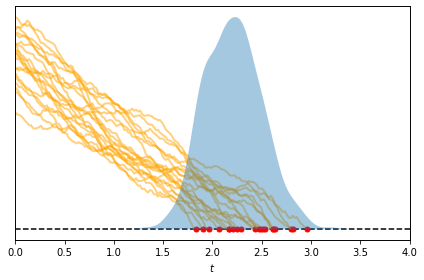

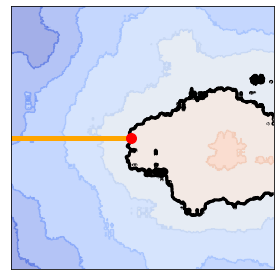

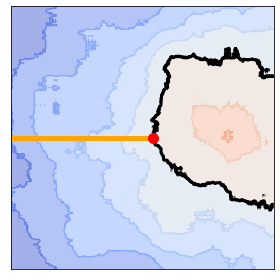

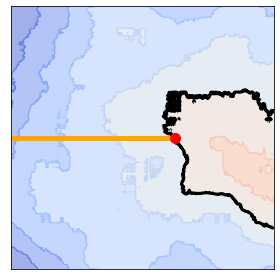

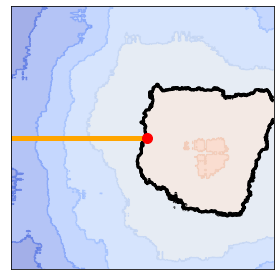

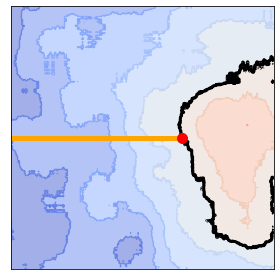

In [37]:
import scipy.interpolate as interp
import tqdm
#import seaborn as sns
#sns.set()

from scipy.stats import gaussian_kde


def first_threshold_crossing_t(vt,ts,vals):
    ft = np.argmax(vals <= vt, axis=1)
    x = np.indices(ft.shape)
    return ts[ft], vals[x,ft].flatten(), ft

fig_plots, ax_plots = plt.subplots()

r_o = np.array([-2, 0])
r_d = np.array([1, 0])

min_t = 0
max_t = 4
rps, ts = utils.ray_points(r_o, r_d, min_t, max_t, 200)
ax_plots.set_xlim(min_t, max_t)
ax_plots.plot(ts, np.zeros_like(ts), "--", color="black")

ax_hist = ax_plots.twinx()

type = "samples"

crossing_ts = []
for i, file in enumerate(tqdm.tqdm(glob.glob(f"2d-reals/*/*{type}*.bin"))):
    realization = np.reshape(np.fromfile(file, dtype=np.cdouble), (1024, 1024)).T
    realization = np.real(realization)

    xs = np.linspace(-2, 2, realization.shape[0])
    ys = np.linspace(-2, 2, realization.shape[1])
    xx, yy = np.meshgrid(xs,ys)

    grid_interp = interp.RegularGridInterpolator((xs, ys), realization.T)

    vals = np.atleast_2d(grid_interp(rps))
    ft_ts, ft_vals, ft_idx = first_threshold_crossing_t(0, ts, vals)
    
    crossing_ts.append(ts[ft_idx[0]])

    if i < 20:
        ax_plots.plot(ts[:ft_idx[0]], vals[0, :ft_idx[0]], color="orange", linewidth=2, alpha=0.5)
        ax_plots.plot(ts[ft_idx[0]], 0, marker=".", color="red", markersize=10)


    if i < 5:
        fig, ax = plt.subplots()
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlim(-2,2)
        ax.set_ylim(-2,2)
        utils.plot_realization(realization, ax, xx, yy)
        ax.plot(rps[:ft_idx[0],0], rps[:ft_idx[0],1], color="orange", linewidth=5)
        
        ax.plot(rps[ft_idx[0],0], rps[ft_idx[0],1], marker=".", color="red", markersize=20)
        
        dir = os.path.join("figures/stimp-didactic/",os.path.split(file)[0])
        os.makedirs(dir, exist_ok=True)
        fig.tight_layout()
        fig.savefig(os.path.join(dir, os.path.basename(file)[:-3] + "pdf"), dpi=300)


if(len(crossing_ts) == 1):
    crossing_ts *= 500
density = gaussian_kde(crossing_ts)
ax_hist.fill(ts,density(ts), alpha=0.4)

#sns.histplot(np.array(crossing_ts), bins=np.linspace(min_t, max_t, 30), ax=ax_hist, kde=True)
#ax_hist.hist(crossing_ts, bins=np.linspace(min_t, max_t, 30), density=True, alpha=0.5, histtype="stepfilled", zorder=10)
ax_hist.set_zorder(5)
ax_hist.set_yticks([])
ax_plots.set_yticks([])
ax_plots.set_xlabel("$t$")
fig_plots.tight_layout()

fig_plots.savefig(f"figures/stimp-didactic/intersects_{type}.pdf", dpi=300)